In [297]:
import numpy as np
import matplotlib.pylab as plt 
from src.helpers import pickle_load
import pandas as pd 

## Numbers

In [513]:
thin_factor = 5 
discard_factor = 200
nsigma = 10

## Load Samples

In [514]:
camb_samples = pickle_load('samples', 'samples_CAMB_uniform_planck_priors_accurate_1') 
camb_samples_thinned = camb_samples.get_chain(flat=True, thin = thin_factor, discard = discard_factor)
camb_logpost = camb_samples.get_log_prob(flat=True, thin = thin_factor, discard = discard_factor)

## LHS

In [515]:
lhs_points = pd.read_csv('lhs/samples_6_2000.csv', index_col=0)
ntrain = lhs_points.shape[0]

In [516]:
median = np.median(camb_samples.flatchain, axis = 0)
mean = np.mean(camb_samples.flatchain, axis = 0)
std = np.std(camb_samples.flatchain, axis = 0)

delta = nsigma * std 
cosmologies = lhs_points * delta + (mean - 0.5 * nsigma * std)

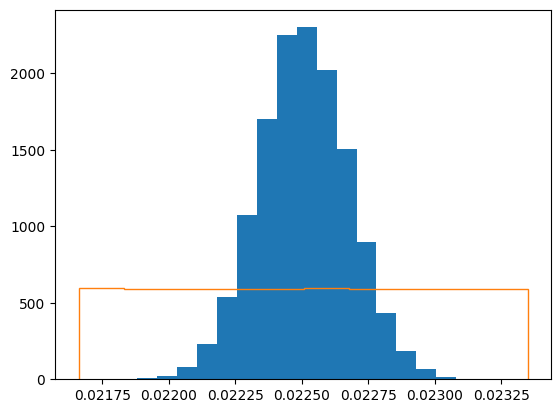

In [518]:
index = 0
plt.hist(camb_samples.flatchain[:,index], density = True, bins = 20)
plt.hist(cosmologies.values[:,index], density = True, histtype='step')
plt.show()

In [490]:
shifts[index]

0.00013037019873161083

In [491]:
min(cosmo.values[:,index])

1.039806520226741

In [487]:
min(cosmo.values[:,index]) - shifts[index]

1.0396761500280094

In [492]:
max(cosmo.values[:,index])

1.0426733180000636

In [489]:
max(cosmo.values[:,index]) + shifts[index]

1.0428036881987952

## Likelihood Calculations

In [431]:
from config import get_config
from src.sampling import generate_priors_uniform, emcee_loglike, emcee_logpost, emcee_logprior_uniform

In [432]:
cfg = get_config('Planck-2018')

In [21]:
uniform_priors = generate_priors_uniform(cfg)

In [434]:
record_logl = np.zeros(ntrain)
for i in range(ntrain):
    record_logl[i] = emcee_loglike(cosmologies.values[i], cfg, uniform_priors).item()
    if (i+1) % (ntrain // 10) == 0:
        print(f'Percentage completed is {(i+1)/ntrain * 100:.2f}')

Percentage completed is 10.00
Percentage completed is 20.00
Percentage completed is 30.00
Percentage completed is 40.00
Percentage completed is 50.00
Percentage completed is 60.00
Percentage completed is 70.00
Percentage completed is 80.00
Percentage completed is 90.00
Percentage completed is 100.00
Percentage completed is 110.00
Percentage completed is 120.00
Percentage completed is 130.00
Percentage completed is 140.00
Percentage completed is 150.00
Percentage completed is 160.00
Percentage completed is 170.00
Percentage completed is 180.00
Percentage completed is 190.00
Percentage completed is 200.00


## Emulator

In [52]:
from src.torchemu.gaussianprocess import GaussianProcess

In [445]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'box-cox')

In [521]:
points = np.log(-record_logl)

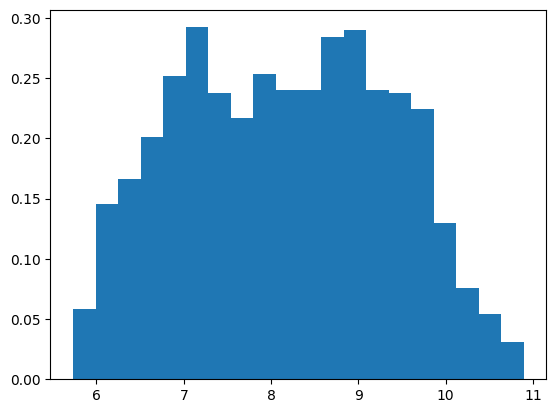

In [522]:
plt.hist(points, bins = 20, density = True)
plt.show()

In [523]:
pt.fit(points.reshape(-1,1))
trans = pt.transform(points.reshape(-1,1))

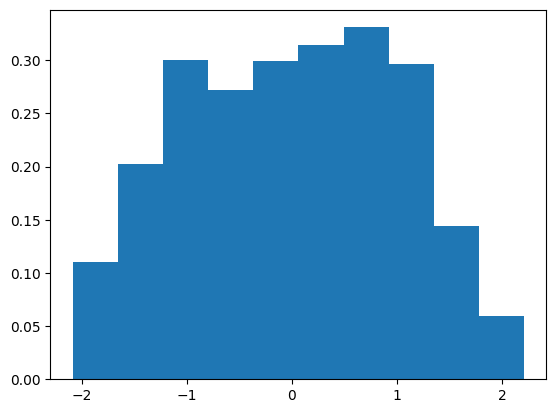

In [524]:
plt.hist(trans, density = True)
plt.show()

In [121]:
# way to get the details of the transformation
# trans_ = (points**pt.lambdas_ - 1.0) / pt.lambdas_
# (trans_ - np.mean(trans_)) / np.std(trans_)

In [122]:
import torch

In [455]:
module = GaussianProcess(cfg, torch.from_numpy(cosmologies.values), torch.from_numpy(trans.reshape(-1)), prewhiten=True)
parameters = torch.randn(7)

In [456]:
opt_params = module.optimisation(parameters, niter=1000, lrate=0.01, nrestart = 5)

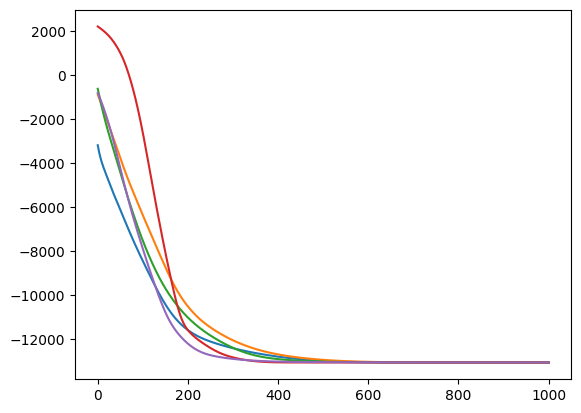

In [457]:
plt.plot(opt_params[0]['loss'])
plt.plot(opt_params[1]['loss'])
plt.plot(opt_params[2]['loss'])
plt.plot(opt_params[3]['loss'])
plt.plot(opt_params[4]['loss'])
plt.show()

In [458]:
record_test_like = np.zeros_like(camb_logpost)

for j in range(camb_logpost.shape[0]):
    testpoint = torch.from_numpy(camb_samples_thinned[j])
    # pred = np.exp(module.prediction(testpoint)) + 1.0001 * min(record_logl)
    pred = np.exp(pt.inverse_transform(module.prediction(testpoint)))
    record_test_like[j] = -pred.item()

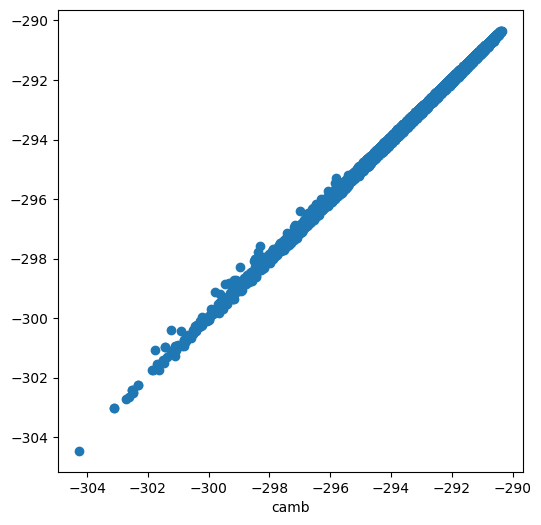

In [459]:
plt.figure(figsize = (6,6))
plt.scatter(camb_logpost, record_test_like + 1.6964435176222046)
plt.xlabel('camb')
plt.show()

In [460]:
frac_acc = (record_test_like + 1.6964435176222046 - camb_logpost) / camb_logpost

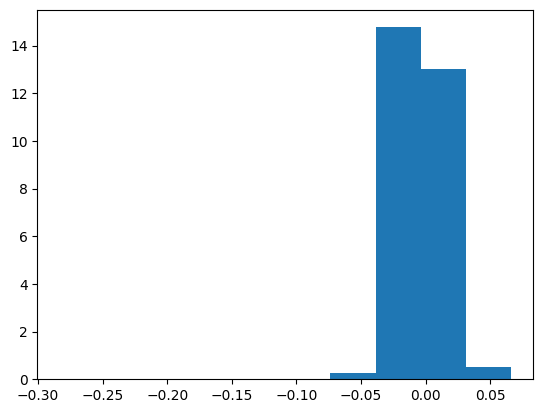

In [461]:
plt.hist(frac_acc * 100, density = True)
plt.show()

## Sampling

In [276]:
def calc_loglike(testpoint):
    testpoint = torch.from_numpy(testpoint)
    pred = module.prediction(testpoint) + 1.0001 * min(record_logl)
    # pred = pt.inverse_transform(module.prediction(testpoint)) + 1.0001 * min(record_logl)
    return pred.item()

In [279]:
def calc_logpost(testpoint, priors):
    logprior = emcee_logprior_uniform(testpoint, priors)
    if np.isfinite(logprior):
        loglike = calc_loglike(testpoint)
        return loglike + logprior
    return -1E32

In [281]:
calc_logpost(camb_samples_thinned[0], uniform_priors)

-292.2481693316579

In [283]:
# import scipy.stats as ss 

# def generate_priors_uniform(cfg, samples_min, samples_max) -> dict:
#     priors = {}
#     for i, name in enumerate(cfg.cosmo.names):
#         loc = samples_min[i]
#         scale = samples_max[i] - samples_min[i]
#         priors[name] = ss.uniform(loc, scale)
#     return priors
    
# samples_min = np.amin(camb_samples.flatchain, axis = 0)
# samples_max = np.amax(camb_samples.flatchain, axis = 0)

# custom_priors = generate_priors_uniform(cfg, samples_min, samples_max)

In [284]:
import emcee

In [290]:
pos = cfg.sampling.mean + 1e-4 * np.random.normal(size=(2 * cfg.ndim, cfg.ndim))
nwalkers = pos.shape[0]
sampler = emcee.EnsembleSampler(
                nwalkers,
                cfg.ndim,
                calc_logpost,
                args= (uniform_priors,))

In [291]:
%%capture
sampler.run_mcmc(pos, cfg.sampling.nsamples, progress=True)

In [292]:
samples_emu = sampler.get_chain(flat=True, thin = thin_factor, discard = discard_factor)

In [295]:
index = 0

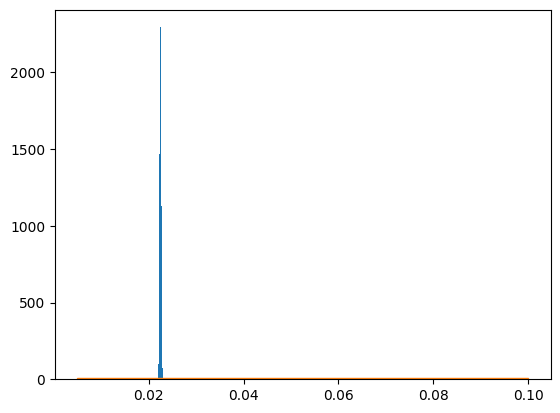

In [296]:
plt.hist(camb_samples_thinned[:,index], density = True)
plt.hist(samples_emu[:,index], density = True, histtype='step')
plt.show()

Idea - use LHS within a box